In [1]:
#Importing required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
#Loading Market Data
df = pd.read_csv('eod-quotemedia.csv', parse_dates=['date'], index_col=False)

#Pivoting market data into daily closing prices, organized by stock tickera
close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')

In [3]:
#Previewing data
close.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478,50.863198,31.425388,64.694095,46.235,39.913360,...,27.668791,35.288928,76.320802,40.023873,22.106665,25.753386,45.480383,71.898827,27.858587,29.447893
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076,50.696766,31.272881,64.712041,46.030,39.860576,...,27.542284,35.059033,76.608168,39.965530,22.082740,25.613675,45.402661,72.934172,28.038932,28.572441
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862,50.937167,30.725650,65.214519,46.420,40.186077,...,27.334452,35.280086,76.650427,40.004426,22.202365,25.734758,46.063299,72.301458,28.181310,28.168387
2013-07-05,30.434568,16.214608,81.821882,54.173381,35.856134,51.371737,31.326707,66.075911,47.000,40.652334,...,27.695899,35.801771,77.394196,40.675380,22.585164,26.060750,46.413048,73.164246,29.396267,29.024598
2013-07-08,30.524021,16.310894,82.951417,53.865799,36.661889,52.037461,31.766285,66.820655,46.625,40.256455,...,27.985057,35.200507,77.968926,40.646208,22.489464,26.228403,46.950626,73.892823,29.576612,29.765365


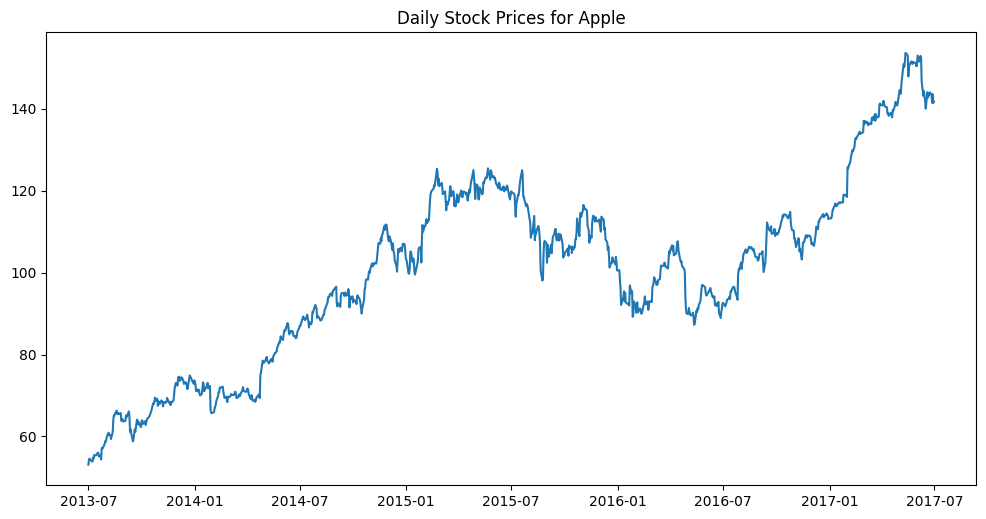

In [4]:
#Visualizing stock prices for Apple [Stock Ticker: AAPL]

figure(figsize=(12, 6), dpi=100)
plt.title("Daily Stock Prices for Apple")
plt.plot(close.AAPL)

In [5]:
'''
Resampling data such that the daily stock prices 
are aggregated to monthly, where that value is represented
by the price of the stock on the last day of the month
'''

def resample_prices(close_prices, freq='M'):
    close = pd.DataFrame(close_prices.resample(freq).last())
    return close

monthly_close = resample_prices(close)

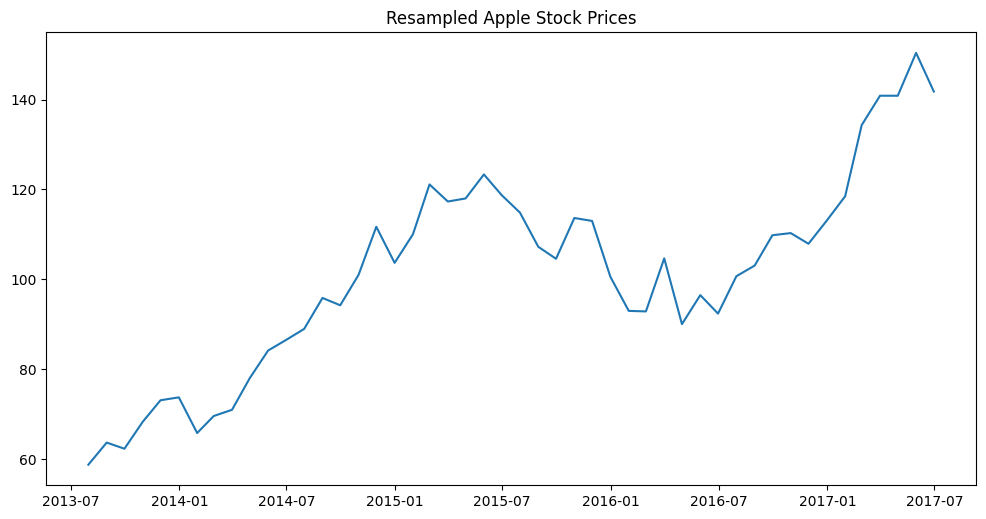

In [6]:
#Viewing resampled prices for Apple

figure(figsize=(12, 6), dpi=100)
plt.title("Resampled Apple Stock Prices")
plt.plot(monthly_close.AAPL)

In [7]:
#We will be using log returns as the indicator for price momentum
#Log returns are calculated as the difference in the log of current price and log of previous price
#Calculating monthly log returns

def compute_log_returns(prices):
    log_return = np.log(prices) - np.log(prices.shift(1))
    return log_return

monthly_close_returns = compute_log_returns(monthly_close)

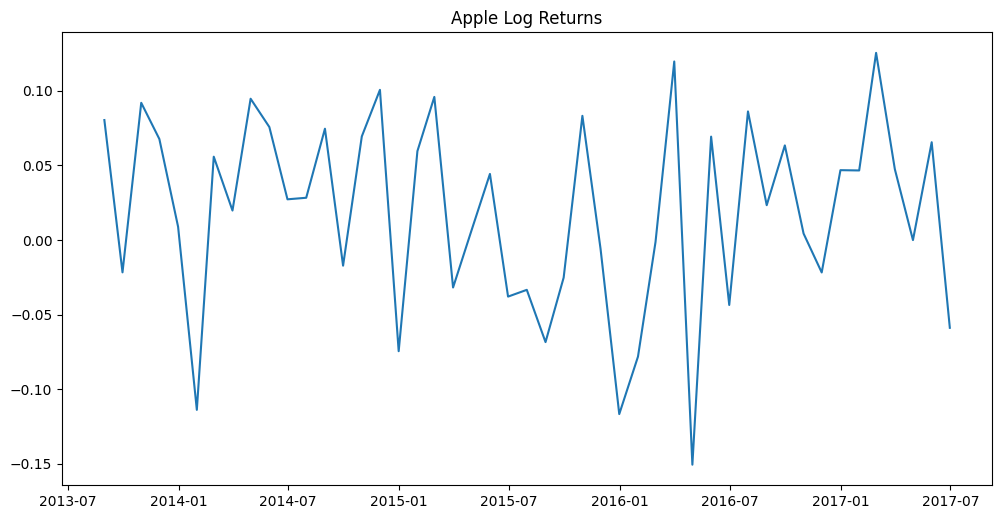

In [8]:
#Visualing log returns

figure(figsize=(12, 6), dpi=100)
plt.title("Apple Log Returns")
plt.plot(monthly_close_returns.AAPL)

In [9]:
#Shifting log returns forward and backwards to view past and future returns for a particular month

def shift_returns(returns, shift_n):
    return returns.shift(shift_n)

prev_returns = shift_returns(monthly_close_returns, 1)
lookahead_returns = shift_returns(monthly_close_returns, -1)

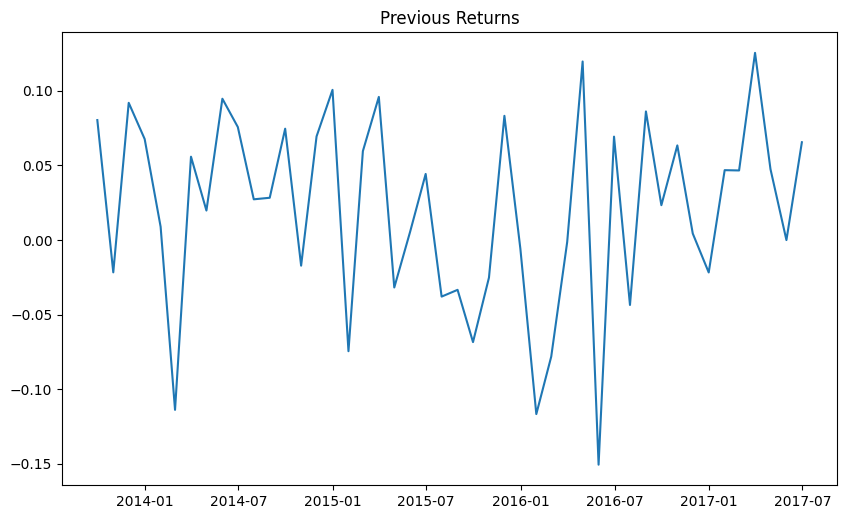

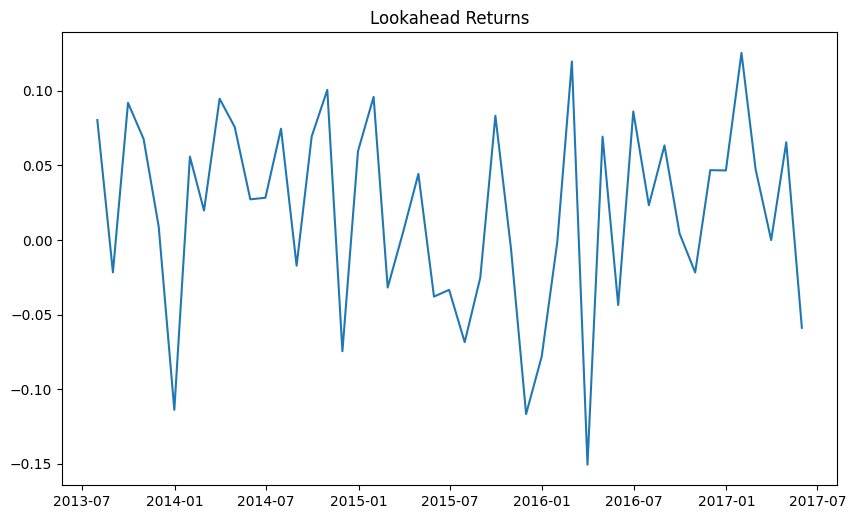

In [10]:
#Visualizing previous returns and lookahead returns
figure(figsize=(10, 6), dpi=100)
plt.title("Previous Returns")
plt.plot(prev_returns.AAPL)

figure(figsize=(10, 6), dpi=100)
plt.title("Lookahead Returns")
plt.plot(lookahead_returns.AAPL)

In [11]:
'''
Generating a trading signal:
----------------------------
On a monthly basis, we rank the stocks based on previous returns.
For a fixed number 'n', we consider the top n stock and go long on these stocks.
For the bottom n stocks, we go short.
Thus, we are implementing a long/short portfolio strategy based on momentum indicator.
'''

def get_top_n(prev_returns, top_n):
    all_stocks=pd.DataFrame(columns=prev_returns.columns)

    for i, row in prev_returns.iterrows():
        this_month = row
        top_stocks = pd.Series(this_month).nlargest(top_n)
        AAA = list(top_stocks.index.values)
        for stock in all_stocks.columns:
            if(stock in AAA):
                all_stocks.loc[i,stock]= True
            else:
                all_stocks.loc[i,stock] = False
    
    for i, row in all_stocks.iterrows():
        all_stocks.loc[i] = all_stocks.loc[i].astype('int64')
    
    return all_stocks

In [12]:
'''
Since we use the same function to find both best and worst performing stocks,
to identify the bottom n stocks, we multiply the previous returns parameter by
-1 in order to convert positive returns to negative and then select the worst 
performing stocks from the top.
'''

#Viewing the 15 best and worst performing stocks

def print_top(df, name, top_n):
    print('{} {}:'.format(top_n, name))
    print(', '.join(df.sum().sort_values(ascending=False).index[:top_n].values.tolist()))

top_bottom_n = 15
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)
print_top(df_long, 'Best Performing Stocks', top_bottom_n)
print_top(df_short, 'Worst Performing Stocks', top_bottom_n)

15 Best Performing Stocks:
NFLX, AAL, INCY, ILMN, NVDA, AMD, FCX, MU, BBY, AVGO, CHK, UAL, WYNN, REGN, WMB
15 Worst Performing Stocks:
FCX, RRC, CHK, NEM, AMD, TRIP, MRO, ARNC, GPS, NRG, WYNN, M, SPLS, COG, ALXN


In [13]:
#Calculating expected porforlio returns
#Assuming we put in an equal amount of investment in each stock

def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    pos_long = df_long*lookahead_returns # compute the long position
    pos_short = df_short*lookahead_returns # compute the short position
    avg_returns = (pos_long - pos_short)/n_stocks # compute average returns
    #print(avg_returns)
    return avg_returns

expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, top_bottom_n)

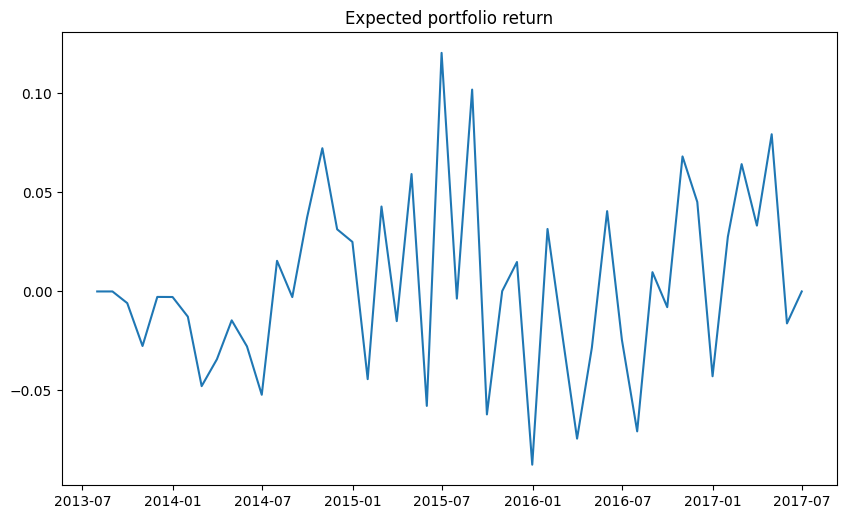

In [14]:
#Visualizing Expected Portflio Returns

figure(figsize=(10, 6), dpi=100)
plt.title("Expected portfolio return")
plt.plot(expected_portfolio_returns.T.sum())

In [15]:
#Calculating the annualized rate of returns

expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.4f}
Standard Error:             {:.4f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.0028
Standard Error:             0.0067
Annualized Rate of Return:  3.43%



In [16]:
#Testing the viability of our strategy by statistical testing
#Assume null hypothesis to be: Mean Return from Trading Signal = 0
#If p-value > alpha (0.05) a.k.a. level of significance, null hypothesis is correct
# If null hypothesis is correct, our strategy is non-viable

from scipy import stats

def analyze_alpha(expected_portfolio_returns_by_date):
    null_hypothesis = 0.0
    t_value, p_value = stats.ttest_1samp(expected_portfolio_returns_by_date, null_hypothesis)
    return t_value, p_value/2

t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha analysis:
 t-value:        {:.3f}
 p-value:        {:.3}
""".format(t_value, p_value))


Alpha analysis:
 t-value:        0.422
 p-value:        0.338



In [17]:
print('Since p-value is 0.338 which is much larger than alpha, our null hypothesis is correct and our strategy nay not be viable.')

Since p-value is 0.338 which is much larger than alpha, our null hypothesis is correct and our strategy nay not be viable.
